**<h1 style="text-align: center">Order Process Analysis and Prediction 🌾</h1>**


## Table of Contents

1. [**Introduction**](#1)
    - Project Description
    - Data Description
2. [**Acquiring and Loading Data**](#2)
	- Importing Libraries and Data
    - Basic Data Exploration
    - Observations Made
3. [**Data Proprocessing**](#3)
    - Drop Irrelevant Columns and Format Datatypes
    - Merging Tables 
    - Feature Engineering
4. [**Exploratory Data Analysis**](#4)
    - Yearly Profit Trends
    - No. of Days Taken in Each Phase
    - Order Accuracy
    - Order Cycle Based on Day of the Week
    - Order Processing Time by Day
    - Express vs. Standard Modes 
    - Effect of Processing Time on the Total Order Cycle
5. [**Statistical Analysis**](#5)
    - A/B Testing
    - T-Testing
6. [**Predictive Modeling**](#6)
    - Linear Regression
7. [**Conclusion**](#7)
    - Insights 
    - Possible Next Steps 

---

# 1

## Introduction
**Part 1**

A Muesli distribution company wants to understand their delivery process. They want to develop KPIs to help them keep track of the health of their business in order to improve the service they offer their customers.

The warehouse manager described the workflow as follows:
- Order received (Day 1) - order processed in warehouse and made ready to ship (normally 2 days) 
- Order leaves warehouse in truck the following day
- Order delivered to customer (handled by logistics company).

The company has full data on 'Order Date' and the 'On Truck Scan' date but have limited visibility of what happens in between. They have occasionally sent some interns into the warehouse to record the ‘Ready to Ship’ date for as many orders as they could. The warehouse manager says they have not changed their processes much in the past year so they think it should be a good estimate. 

Customers can send orders every day but the warehouse only works Monday to Friday so any orders received on the weekends wait until Monday to be actioned.

Trucks Leave the warehouse on Mondays, Wednesdays and Fridays.

Orders leave on trucks the day after they are made ready for shipping (or two days later if there is no truck).
Customers can pay for Express Processing that means the orders leave on the truck the day the order is ready for shipping.

The logistics company has said they have on average 3 day delivery times to all locations. They transport goods on weekends but only deliver to customers from their local distribution centers on weekdays. The Muesli company has some data about exact delivery dates for a number of shipments that was gathered via marketing promotions they ran where customers scanned a QR code on the package in order to register for a prize. (We assume customers always scanned the code on the day of arrival).

**Part 2**

After successfully finding out the current state of the warehouse, the company seeks to further understand the possible avenues to optimize the process with a goal to improve the time that is taken to deliver the goods.

The team lead requires you to perform an A/B test to check the Lead Time for each processing type and if there is some significant difference.

The work you did in the EDA can be carried forward. 
You might have already identified some differences during your EDA but now you must set up the A/B test using your know-how on sampling and statistical-tests.

The warehouse manager also requested that you look into some Machine Learning to predict future Lead Times given the historical data.

The Team Lead has directed you to create a simple Linear Regression model. Just one factor which is the shipping mode to predict the Lead Times. Create a model, train it and interpret the results.

<img src='order-process.png'>

### Project Description

**Objective:** 

To analyze and improve the muesli distribution process by performing exploratory data analysis (EDA) to uncover key insights, developing a predictive model using linear regression to forecast future trends, and developing KPIs to enhance business performance.

<p>&nbsp;</p>

**Questions to be Answered:**

1. Which days have the shortest order life cycle? 
2. Is there a connection between what day an order is received and how long the order takes to be delivered?
3. Are the warehouse manager's estimation on the Order Lead Times accurate?
4. Is there a significant difference in processing between Express and Standard shipping modes?
5. How is the business doing overall?

<p>&nbsp;</p>

### Data Description

**Content:** 

This dataset is an Excel file containing four seperate sheets: Orders, Campaign Data, Order Process Data, InternData Study. 

---

# 2

## Acquiring and Loading Data
### Importing Libraries and Data

In [117]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

raw_orders = pd.read_excel('data/Muesli Project raw data.xlsx', 0, skiprows=1, index_col='Index')
raw_campaign = pd.read_excel('data/Muesli Project raw data.xlsx', 1)
raw_process = pd.read_excel('data/Muesli Project raw data.xlsx', 2)
raw_intern_study = pd.read_excel('data/Muesli Project raw data.xlsx', 3)

In [111]:
# Get the viridis colormap
sns.color_palette("viridis", as_cmap=True)

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

### Basic Data Exploration

In [ ]:
# Show rows and columns count
print(raw_orders.shape)
print(raw_campaign.shape)
print(raw_process.shape)
print(raw_intern_study.shape)

In [ ]:
# Check Data Types
print(raw_orders.info())
print(raw_campaign.info())
print(raw_process.info())
print(raw_intern_study.info())

In [ ]:
# Check Duplicates
print(raw_intern_study.duplicated().value_counts())
print(raw_orders.duplicated().value_counts())
print(raw_process.duplicated().value_counts())
print(raw_campaign.duplicated().value_counts())

### Observations made: 
- `Order Date` columns need to be in datetime format. 
- Certain columns are not relevant to the analysis and must be dropped.
- The tables _Order Process Data_ and _InternData Study_ have some redundant rows. Since an Order ID must be unique to every order, removing these duplicates would give us more accurate results. 

---

# 3

## Data Preprocessing

### Drop Irrelevant Columns and Format Datatypes

In [118]:
# Drop Irrelevant Columns
raw_orders.drop(['Customer ID', 'Ship Mode', 'Postal Code', 'Product ID', 
                 'Category', 'Sub-Category'], axis=1, inplace=True)
# Drop Duplicates
raw_orders.drop_duplicates(inplace=True)
raw_intern_study.drop_duplicates(inplace=True)
raw_process.drop_duplicates(inplace=True)

# Format datatypes
raw_orders['Order Date'] = pd.to_datetime(raw_orders['Order Date'])
raw_process['Order Date'] = pd.to_datetime(raw_process['Order Date'])

__Justification:__ In the orders table, details about the customers, their shipping preferences, or the product are not needed to analyze the operations involved in the ordering process since our EDA is not focused on analyzing customer behavior.<br>
In addition, the 'Postal Code' column contained some null values, and since we have other columns to tell us about the region, we can drop this column.

### Merging Tables 

In [ ]:
df_merged = pd.merge(raw_orders, raw_process, left_on=['Index', 'Order ID', 'Order Date'], right_on=['Row ID', 'Order ID', 'Order Date'], how='left')
df_merged = pd.merge(df_merged, raw_campaign, on=['Order ID', 'Customer Name'], how='left')
df_merged = pd.merge(df_merged, raw_intern_study, on='Order ID', how='left')

df_merged.info()

### Feature Engineering
To effectively analyze the date data, we extracted the day and year from the all the datetype columns. After evaluating the monthly trend of orders, we observed little variation, so we later excluded this component from our preprocessing steps.

In [120]:
# Extract day of week and day components
df_merged['Order Day'] = df_merged['Order Date'].dt.day_name()
df_merged['Order Year'] = df_merged['Order Date'].dt.year

df_merged['On Truck Day'] = df_merged['On Truck Scan Date'].dt.day_name()

df_merged['Ready to Ship Day'] = df_merged['Ready to Ship Date'].dt.day_name()
df_merged['Pickup Day'] = df_merged['Pickup Date'].dt.day_name()

df_merged['Arrival Scan Day'] = df_merged['Arrival Scan Date'].dt.day_name()

---

# 4

## Exploratory Data Analysis

### Yearly Profits Trends

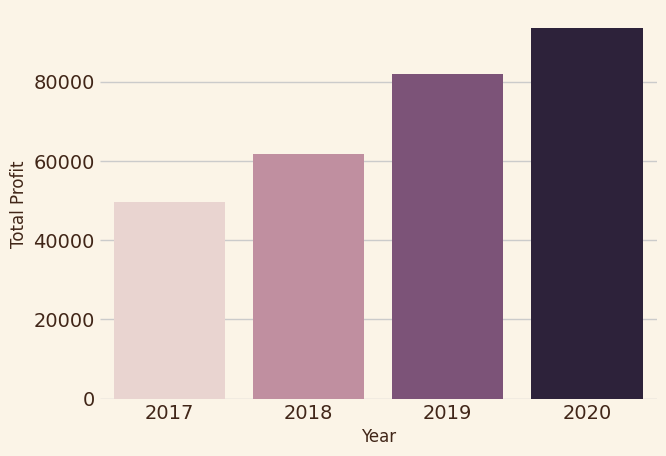

In [121]:
yearly_profit = df_merged.groupby('Order Year')['Profit'].sum().reset_index()
sns.barplot(x='Order Year', y='Profit', data=yearly_profit, hue='Order Year', legend=False);
plt.ylabel('Total Profit');
plt.xlabel('Year');

**Observations:** There seems to be a steady increase in profits over the years.

### No. of Days Taken in Each Phase 
Recall that there are 3 main stages to the order delivery process: 
1. Order Processing 
2. Order Pickup 
3. Order Delivery

In [122]:
# Calculate time taken for each stage
df_merged['Pickup Time(days)'] = (df_merged['Pickup Date'] - df_merged['Ready to Ship Date']).dt.days
df_merged['Processing Time(days)'] = (df_merged['Ready to Ship Date'] - df_merged['Order Date']).dt.days
df_merged['Delivery Time(days)'] = (df_merged['Arrival Scan Date'] - df_merged['Pickup Date']).dt.days

#Total order life cycle = Lead Time
df_merged['Total Lead Time(days)'] = (df_merged['Arrival Scan Date'] - df_merged['Order Date']).dt.days

In [129]:
# Describe the statistics for each time metric
time_metrics = ['Processing Time(days)', 'Pickup Time(days)', 'Delivery Time(days)', 'Total Lead Time(days)']
df_merged[time_metrics].describe()

,Processing Time(days),Pickup Time(days),Delivery Time(days),Total Lead Time(days)
count,418.000000,418.000000,41.000000,668.000000
mean,4.157895,1.643541,4.707317,10.886228
std,1.949961,0.966945,0.715678,2.878174
min,0.000000,0.000000,3.000000,3.000000
25%,3.000000,1.000000,5.000000,9.000000
50%,5.000000,2.000000,5.000000,12.000000
75%,6.000000,2.000000,5.000000,13.000000
max,8.000000,3.000000,6.000000,17.000000


### Order Accuracy
Refers to the percentage of orders delivered on time. It is expected to be within 7-8 days.

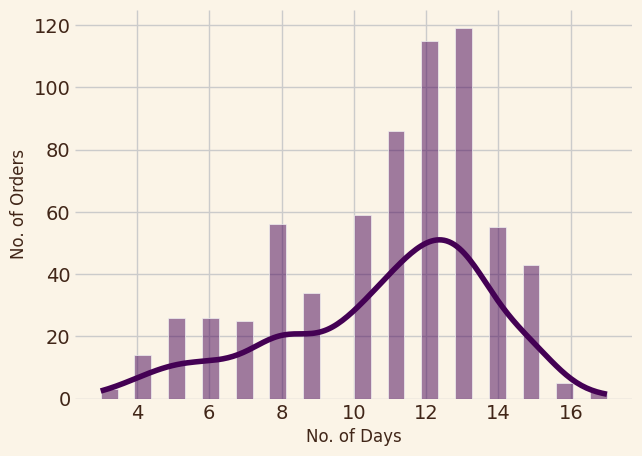

In [137]:
sns.histplot(df_merged['Total Lead Time(days)'], bins=30, kde=True);
plt.xlabel('No. of Days');
plt.ylabel('No. of Orders');

In [ ]:
df_merged['Total Lead Time(days)'].describe()

**Observation:** The majority of orders took a total of 13 days. The average delivery time is around 11 days. This is way more than the expected order cycle length. 

**Assumption:** The longer order times are for those that were placed on weekends, hence affecting the overall mean. Let's check the order cycle based on each day of the week.

### Order Cycle Based on Day of the Week

C:\Users\fatim\AppData\Local\Temp\ipykernel_4504\1166026117.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Order Day', y='Average Order Time(days)', data=mean_cycle_per_day, palette='viridis');


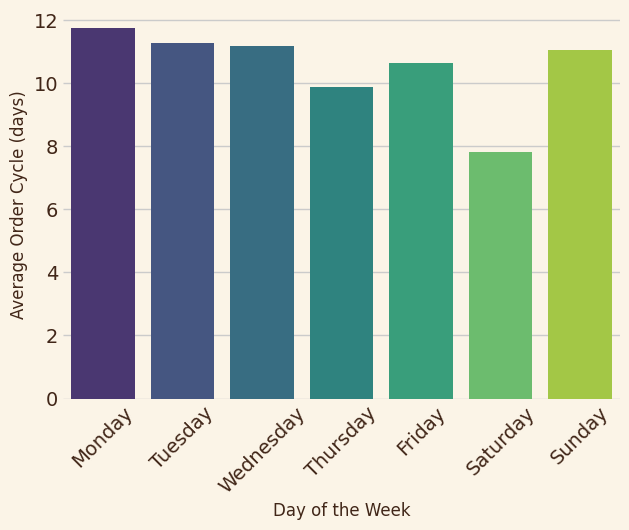

In [143]:
# Calculate the mean cycle per day
mean_cycle_per_day = df_merged.groupby('Order Day')['Total Lead Time(days)'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

mean_cycle_per_day.columns = ['Order Day', 'Average Order Time(days)']

sns.barplot(x='Order Day', y='Average Order Time(days)', data=mean_cycle_per_day, palette='viridis');
plt.xlabel('Day of the Week');
plt.ylabel('Average Order Cycle (days)');
plt.xticks(rotation=45);

**Observations:**
- Orders placed on Saturdays were delivered the quickest.
- Assumption was proven wrong since almost all days have long order cycles. 

### Order Processing Time by Day
This is the number of days between `Order Received Date` to `Ready to Ship Date`. It indicates the efficiency of the warehouse. 

The warehouse manager mentioned that orders are processed and ready to ship within 4 business days. Let's see how accurate this is.

C:\Users\fatim\AppData\Local\Temp\ipykernel_4504\861665019.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_processing_time_per_day, palette='viridis');


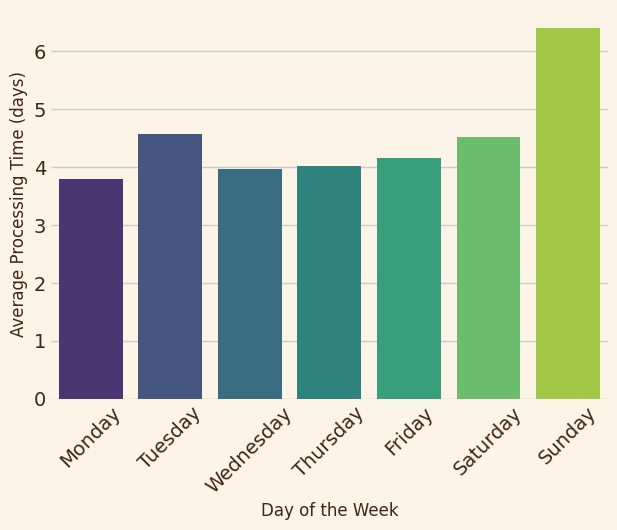

In [149]:
# Calculate the mean processing time
mean_processing_time_per_day = df_merged.groupby('Order Day')['Processing Time(days)'].mean().\
reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

sns.barplot(data=mean_processing_time_per_day, palette='viridis');
plt.xlabel('Day of the Week');
plt.ylabel('Average Processing Time (days)');
plt.xticks(rotation=45);

In [151]:
mean_processing_time_per_day.mean()

np.float64(4.48813138377558)

**Observations:** 
- The average is coming out to be around 4 days, so we can say the warehouse is working as expected.
- The processing time on Sundays is taking the longest, which makes sense since orders are backlogged on the weekends.
- However, orders placed on Saturdays are still being processed relatively quick. 

### Express vs. Standard Modes 
Here we will determine weather Express orders are processed quicker than Standard orders. 

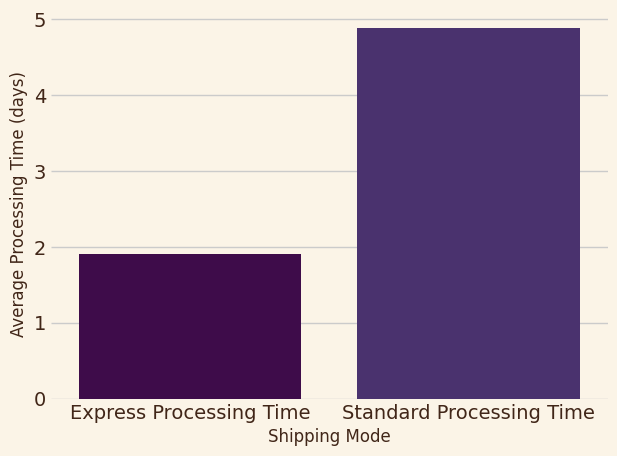

In [177]:
# Copy over Ship Mode to new DataFrame 
express_orders = df_merged[df_merged['Ship Mode'] == 'Express']
regular_orders = df_merged[df_merged['Ship Mode'] == 'Standard Processing']
df_merged['Express Processing Time'] = (express_orders['Processing Time(days)'])
df_merged['Standard Processing Time'] = (regular_orders['Processing Time(days)'])

# Calculate average processing times 
average_processing_times = df_merged.groupby('Ship Mode')[['Express Processing Time', 'Standard Processing Time']].mean()

# Plotting
sns.barplot( data=average_processing_times);
plt.xlabel('Shipping Mode');
plt.ylabel('Average Processing Time (days)');


We can see Express Shipping mode is much faster, but exactly how much? For this we need to get the percentage.

In [156]:
express_avg_time = express_orders['Processing Time(days)'].mean()
regular_avg_time = regular_orders['Processing Time(days)'].mean()

# Calculate the percentage 
percentage = ((regular_avg_time - express_avg_time) / regular_avg_time) * 100
print(percentage)

60.8478517784301


### Effect of Processing Time on the Total Order Cycle

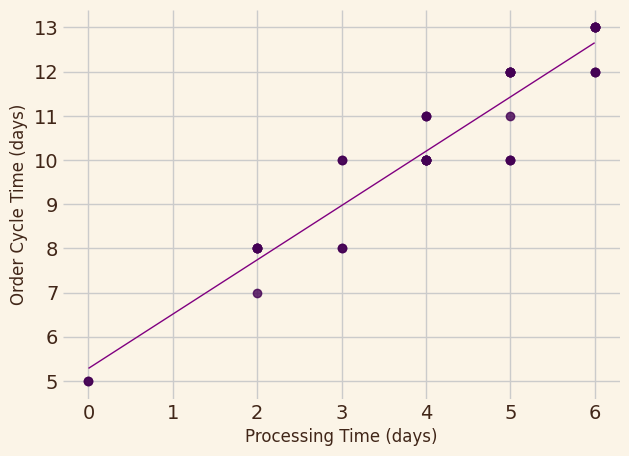

In [158]:
# Create the scatter plot with a linear regression line
sns.regplot(x='Processing Time(days)', y='Total Lead Time(days)', data=df_merged, line_kws={'color':'purple', 'linewidth':1},  ci=None)

# Label the axes and add a title
plt.xlabel('Processing Time (days)');
plt.ylabel('Order Cycle Time (days)');

**Observation:** Generally we can see that the greater the processing time, the longer the order takes to be completed.

---

# 5
## Statistical Analysis
### A/B Testing

We saw previously that Express Shipping took around 60% less processing time than Standard shipping. Let's also view this as a box plot to understand the spread of data. 

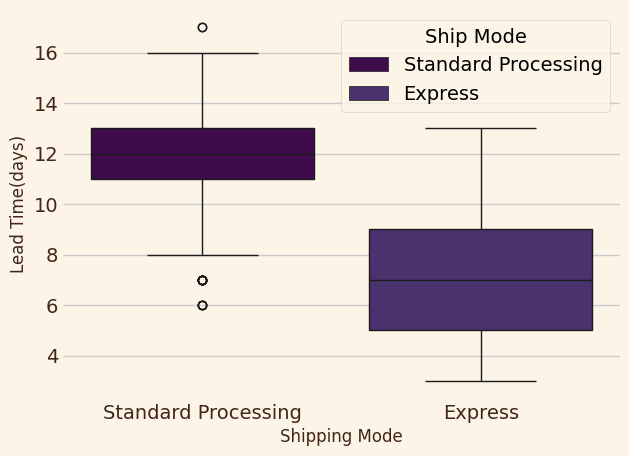

In [168]:
# Box plot
sns.boxplot(x='Ship Mode', y='Total Lead Time(days)', data=df_merged, hue='Ship Mode');
plt.ylabel('Lead Time(days)');
plt.xlabel('Shipping Mode');

**Observations:**
- Standard processing mode also has some 'extreme' values, indicating occasional siginificant delays. 
- The box for Express processing is wider, indicating greater variability in delivery times. This suggests that although Express processing can be faster on average, the delivery times are less consistent compared to Standard. 

### T-Testing
A t-test is a statistical test used to determine if there is a significant difference between the means of two groups. To perform a t-test, we sampled 1000 random orders from each category of shipping mode.

In [171]:
import scipy.stats as stats

# Filter data for each shipping mode
express = df_merged[df_merged['Ship Mode'] == 'Express']
standard = df_merged[df_merged['Ship Mode'] == 'Standard Processing']

# Sample 1000 orders from each group 
express_sample = express.sample(n=1000, replace=True, random_state=1)
standard_sample = standard.sample(n=1000, replace=True, random_state=1)

# Perform t-test
stats.ttest_ind(express_sample['Total Lead Time(days)'], standard_sample['Total Lead Time(days)'], nan_policy='omit', equal_var=False)

TtestResult(statistic=np.float64(-14.22978730120388), pvalue=np.float64(2.3627255117107105e-32), df=np.float64(203.5712611376473))

**T-Test Results:** 
- T-Statistic: ~-14.798

This large negative t-statistic indicates a substantial difference between the two groups. A negative value implies that the lead time for express shipping is significantly lower than that for standard shipping.

- P-value: ~1.542828961340e-34 

This value is much lower than the significance value of 0.05. It provides strong evidence against the null hypothesis.The null hypothesis here would be that there is no difference in lead times between the two shipping modes.

- Mean Difference: ~4.17 days

Express shipping leads to a reduction in lead time of approximately 4.17 days compared to standard shipping.

- 95% Confidence Interval: (3.980341024911013, 4.352992308422319)

This means we are 95% confident that the true mean difference in lead times between standard and express shipping lies within this interval.

# 6
## Predictive Modeling  
### Linear Regression

#### _Model Building_

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Filtering out null values
df_filtered = df_merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['Total Lead Time(days)', 'Ship Mode'])
df_filtered = df_filtered.reset_index(drop=True)

# Encode 'Ship Mode'
df_filtered['Ship Mode'] = df_filtered['Ship Mode'].map({'Standard Processing': 0, 'Express': 1})

# Define features and target
X = df_filtered[['Ship Mode']]
y = df_filtered['Total Lead Time(days)']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add intercept to training data
X_train = sm.add_constant(X_train)

# Fitting the model
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
# print(model.summary())

# Evaluate the model
# Add intercept to testing data
X_test = sm.add_constant(X_test)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 3.558406292710392
R-squared: 0.5102988006169071


In [173]:
# Comparison
print(df_merged['Total Lead Time(days)'].mean())
print(y_pred.mean())

10.886227544910179
11.023476617269722


#### _Interpretation of Results_
 An R-squared value of 0.510 means that 51% of the variance in Lead Time can be explained by the Shipping Mode. This indicates that nearly half of the variation in Lead Time is accounted for by whether the shipping
 is Express or Standard. This also means that the remaining percentage of the variance in Lead Time is due to other factors not included in this model.


#### _Model Evaluation_ 
**Are the results good?**

The R-squared value of 0.510 is moderate. It indicates that while the shipping mode is a significant predictor of lead time, there are other factors influencing lead time that are not captured by this model.

**Is the model good?**

The model has some predictive power but is not highly accurate. With an R-squared of 0.510, it explains just over half of the variance in lead times.

The model could be improved by incorporating additional relevant features that impact lead time.

**Suggestion:** to consider other factors e.g. order processing day, truck schedules, customer location, origin channel, order quantity, etc.

**Issues with the Model**

The model uses only one predictor, 'Ship Mode'. Lead times are likely influenced by multiple factors, so the model may be oversimplified.

# 7

## Conclusion

### Insights 
Although the business is growing steadily over the years in terms of profits, the company has some inaccurate estimations on how long their orders actually take to deliver. This could negatively impact customer satisfaction. Furthermore, there are tons of inconsistencies and missing data, especially in the data collected by the interns. Data quality issues can hinder the accuracy of insights and predictions. 

### Possible Next Steps
Areas to expand on:
- Look into other factors that are possibly affecting lead times. 
- Data collection improvements: implement standardized procedures for data entry and collection.
- Identify potential bottlenecks in the process workflow. 

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b689e16b-e36c-4f8c-b17a-b3e876352669' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>